In [1]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDOptimizer, SVDAdamOptimizer
from src.layers import SVDDense

In [3]:
plt.style.use('dark_background')

# Benchmarking using UCI datasets

Benchmarking singular value decomposed kernels using UCI datasets. <br>
Comparing regular MLPs versus MLP with SVD kernels. <br>
* UCI ... dataset
* UCI ... dataset

In [4]:
uci_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases"

## Adult Data

In [5]:
data_name = 'adult'

### Data loading

In [6]:
# Get information about dataset
information = requests.get(os.path.join(uci_directory, data_name, data_name + '.names'))
print(information.content.decode('utf-8'))

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [7]:
# Columns extracted from information (manual)
# names =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs' ,'restecg', 'thalach', 'exang','oldpeak','slope','ca','thal', 'num']
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
         'race', 'sex', 'capital-gain', 'captial-loss', 'hours-per-week', 'native-country', '50K']
# Read data
df = pd.read_csv(os.path.join(uci_directory, data_name, data_name + '.data'), encoding = 'latin', names=names, index_col=False, na_values='?')
# drop nan's
df = df.dropna()
# Get categorical features (5 is maximal number of discrete values --> taken from information)
categorical_columns = [col for col in df if np.unique(df[col]).size < 50]
# Get numerical features
numerical_columns = [col for col in df if col not in categorical_columns]
# Convert to correct dtype
df[numerical_columns] = df[numerical_columns].astype(float)
# Show data header
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,50K
0,39.0,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Visualization

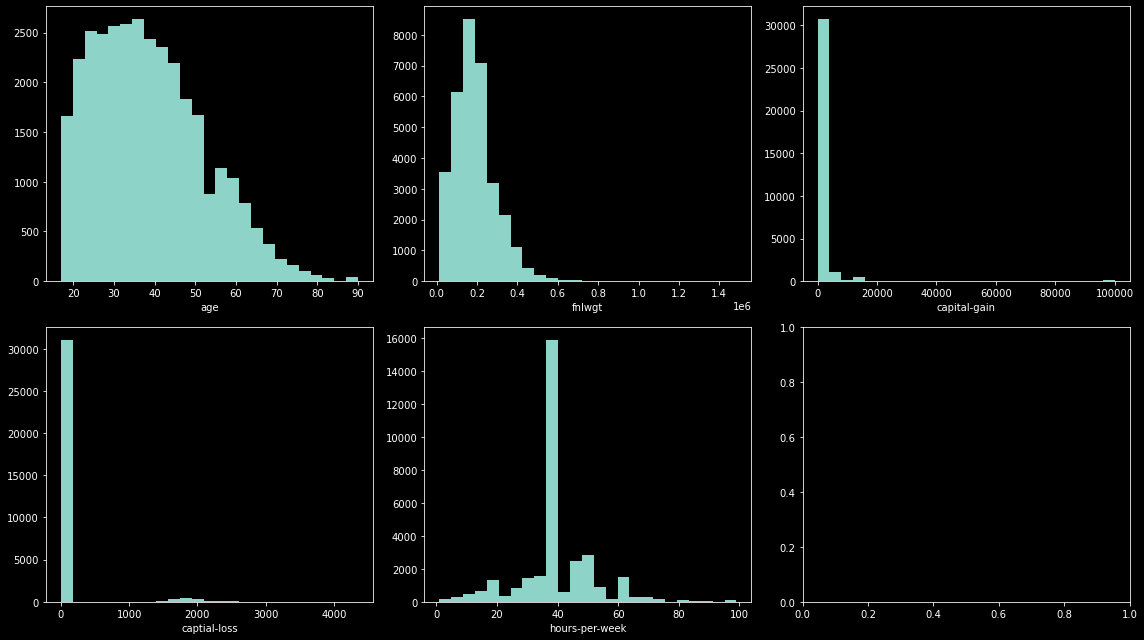

In [8]:
rows = int(np.sqrt(len(numerical_columns)))
cols = int(np.ceil(len(numerical_columns)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for ax, col in zip(axes.reshape(-1)[:len(numerical_columns)], numerical_columns):
    ax.hist(df[col].values, bins=25)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

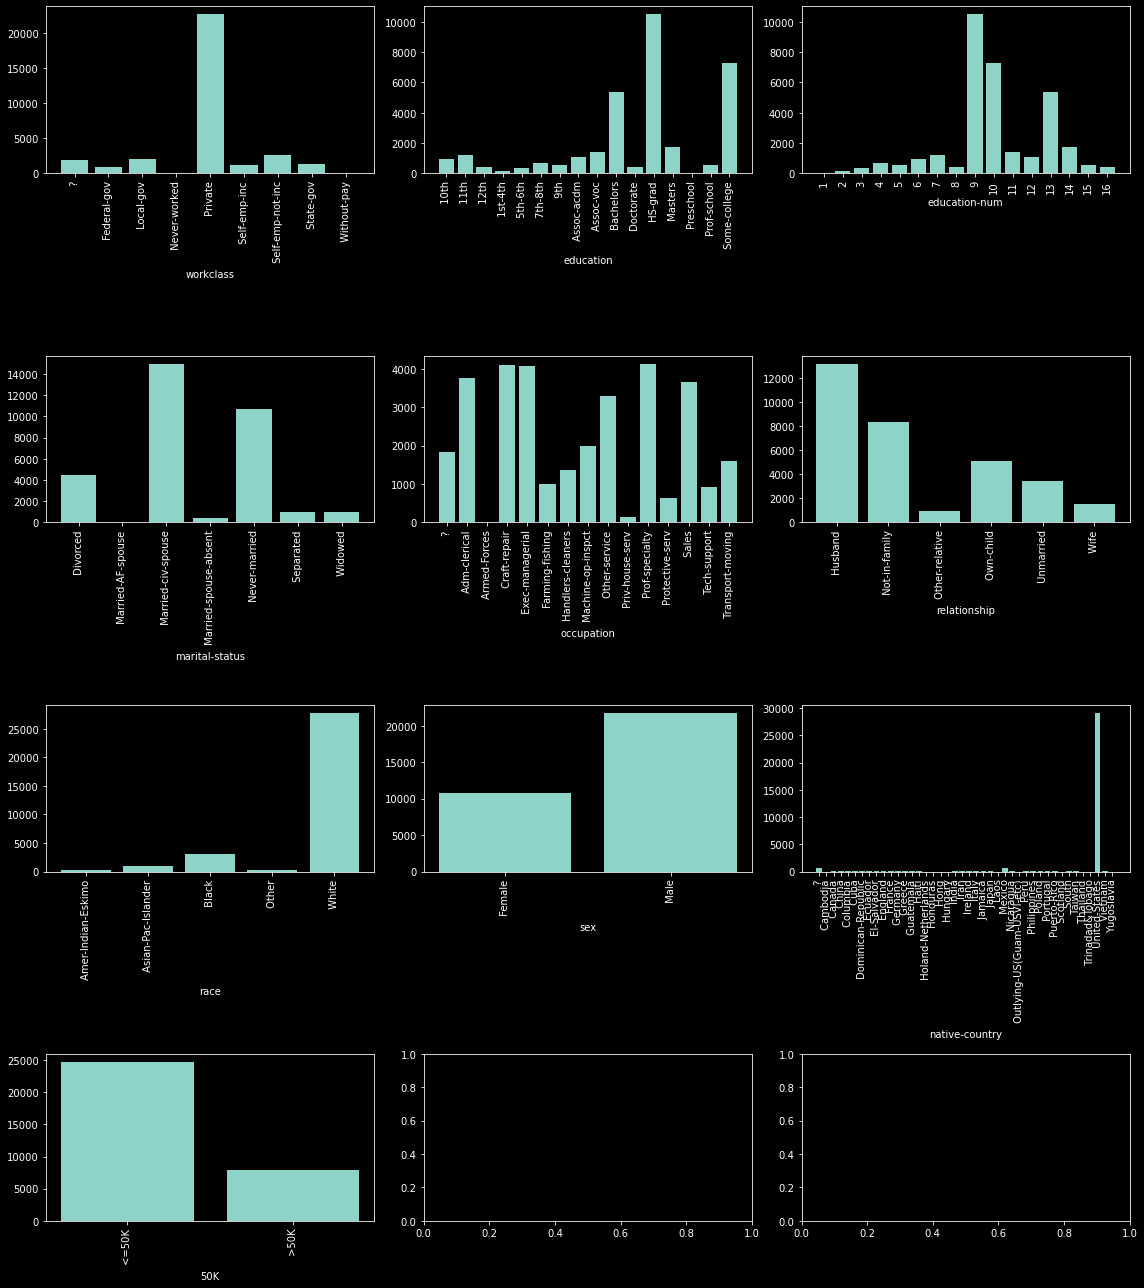

In [9]:
cols = int(np.sqrt(len(categorical_columns)))
cols = 3
rows = int(np.ceil(len(categorical_columns)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 18))
for ax, col in zip(axes.reshape(-1)[:len(categorical_columns)], categorical_columns):
    values, counts = np.unique(df[col].values, return_counts=True)
    ax.bar(values, counts)
    ax.set_xticks(values)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

### Preprocessing

In [10]:
from sklearn.preprocessing import quantile_transform

In [11]:
# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_columns)
# Normalize features
df[numerical_columns] = quantile_transform(df[numerical_columns], n_quantiles=25, output_distribution='normal')
# Show data header
df.head(1)

,age,fnlwgt,capital-gain,captial-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,50K_ <=50K,50K_ >50K
0,0.104633,-1.171915,1.468964,-5.199338,-0.104633,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Data pipeline

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Get target columns
target_columns = [col for col in df if '50K' in col]
x, y = df.drop(target_columns, axis=1).values, df[target_columns].values[:, 0]
# Split data
split = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, shuffle=True)

In [14]:
batch_size = 32
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 123) (32,)


### Model

In [15]:
n_layers = 1
units = 8
activation = 'elu'

units_list = [8, 16, 32, 64, 128, 256]
iterations = []
for it in range(1):
    results = []
    for units in units_list:
        inputs = tf.keras.Input(shape=x.shape[1:])
        hidden = inputs
        for layer in range(n_layers):
            hidden = tf.keras.layers.Dense(units, activation)(hidden)
        outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)

        # Learning rate
        learning_rate = 10e-5
        # Make loss function, accuracy function & optimizer
        loss_fn = tf.keras.losses.BinaryCrossentropy()
        accuracy_fn = tf.keras.metrics.BinaryAccuracy()
        optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)
        # Make & compile model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
        # Number of epochs
        epochs = 100
        # Simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=3)
        # Fit model
        history = model.fit(dataset, validation_data=(x_test, y_test), epochs=epochs, callbacks=[early_stopping], verbose=0)
        # Accuracies
        train_accuracy = accuracy_fn(model.predict(x_train), y_train)
        test_accuracy = accuracy_fn(model.predict(x_test), y_test)
        results.append((train_accuracy.numpy(), test_accuracy.numpy()))
    iterations.append(results)

Epoch 00039: early stopping
Epoch 00026: early stopping
Epoch 00029: early stopping
Epoch 00025: early stopping
Epoch 00032: early stopping
Epoch 00022: early stopping


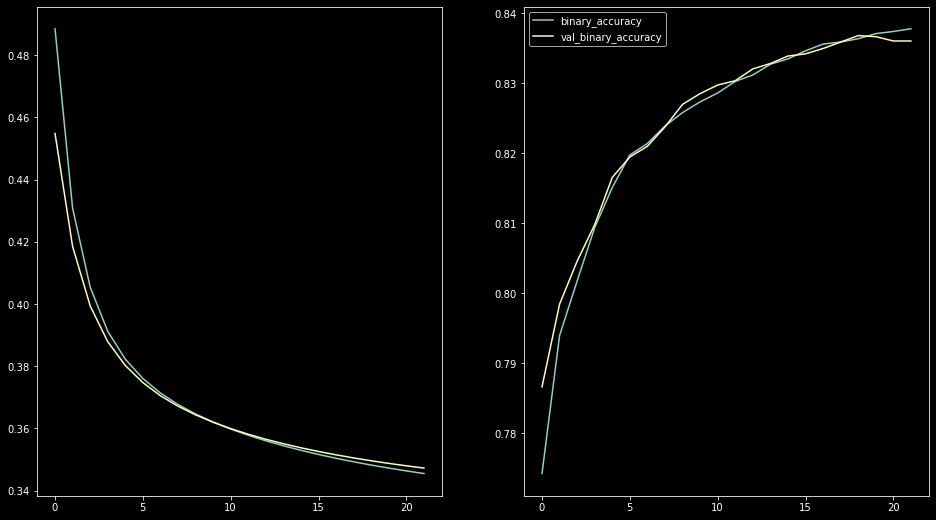

In [16]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
plt.legend()
plt.show()

In [17]:
t = np.array(iterations)

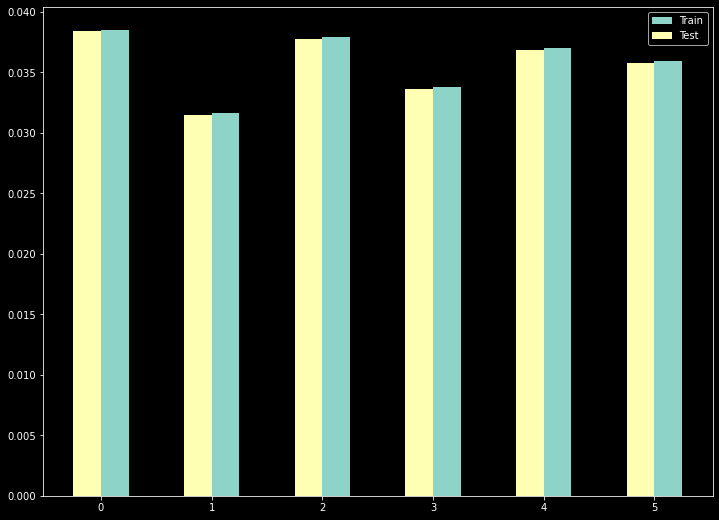

In [18]:
plt.figure(figsize=(12, 9))
a, b = np.mean(t[..., 0], axis=0), np.mean(t[..., 1], axis=0)
a_, b_ = np.std(t[..., 0], axis=0), np.std(t[..., 1], axis=0)
plt.bar(x=np.arange(len(units_list)) + 0.125, width=0.25, height=a-0.8, yerr=a_, label='Train', ecolor='grey')
plt.bar(x=np.arange(len(units_list)) - 0.125, width=0.25, height=b-0.8, yerr=b_, label='Test', ecolor='grey')
plt.legend()
plt.show()

In [208]:
import tensorflow as tf


def orthogonality_number(weights: tf.Tensor) -> tf.float32:
    """Calculate kappa measure.

    Notes
    -----
    k = ||1 - W@W.T||

    Parameters
    ----------
    weights: tf.Tensor
        Orthogonal matrix [(B) x ](N x R)

    Returns
    -------
    tf.float32
        Orthogonality measure kappa
    """
    shape = tf.shape(weights)
    return tf.linalg.norm(tf.eye(shape[-1]) - tf.transpose(weights)@weights, axis=[-1, -2])


def conditioning_number(weights: tf.Tensor) -> tf.float32:
    """Calculate conditioning number.

    Notes
    -----
    k = S_max / S_min

    Parameters
    ----------
    weights: tf.Tensor
        Singular value vector [(B) x ](R)

    Returns
    -------
    tf.float32
        Conditioning number of matrix with given singular values
    """
    return tf.reduce_max(weights, axis=-1) / tf.reduce_min(weights, axis=-1)


In [233]:
from typing import *
from src.optimizers.utils import *
import functools

import six

from tensorflow.python.distribute import distribution_strategy_context as distribute_ctx
from tensorflow.python.distribute import parameter_server_strategy
from tensorflow.python.distribute import values as ds_values
from tensorflow.python.eager import backprop
from tensorflow.python.eager import context
from tensorflow.python.eager import monitoring
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras import backend
from tensorflow.python.keras import initializers
from tensorflow.python.keras.engine import base_layer_utils
from tensorflow.python.keras.optimizer_v2 import learning_rate_schedule
from tensorflow.python.keras.optimizer_v2 import utils as optimizer_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils import tf_inspect
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gen_resource_variable_ops
from tensorflow.python.ops import gradients
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.saved_model import revived_types
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export
class SVDAdam(tf.keras.optimizers.Optimizer):
    """Adam Optimizer function for SVD based architectures with keras optimizer compatibility"""
    def __init__(self, model: tf.keras.Model, learning_rate: float, nu: float, beta: float = 0.9, gamma: float = 0.999,
                 name: Optional[str] = None):
        """Initialize optimizer

        Parameters
        ----------
        learning_rate: float
            Learning rate for optimizer
        nu: float
            Learning rate for cayley transform
        beta: float
            Momentum parameter
        gamma: float
            Velocity parameter
        """
        super(SVDAdam, self).__init__(name=name)
        self.learning_rate = learning_rate
        self.nu = nu
        self.beta = beta
        self.gamma = gamma
        self.model = model
        self.epsilon = 10e-8
        self.names = [var.name for name, layer in unpack([self.model]) for var in layer.variables]
        # Indices of svd variables
        self.slices = [
            slice(idx, idx + 3) for idx, name in enumerate(self.names) if ('svd' in name) & ('U' in name)]
        
    def _create_slots(self, var_list):
        # Create slots for momentum and velocity
        for variable in var_list:
            self.add_slot(variable, "momentum")
            self.add_slot(variable, "velocity")
            
    def _apply_adam(self, grad, var):
        # Get slots
        momentum = self.get_slot(var, "momentum")
        velocity = self.get_slot(var, "velocity")
        # Calculate updated variables
        momentum.assign(self.beta * momentum + (1. - self.beta) * grad)
        velocity.assign(self.gamma * velocity + (1. - self.gamma) * grad**2)
        # Apply iteration scaling
        momentum_ = momentum  / (1. - tf.math.pow(self.beta, tf.cast(self.iterations + 1, momentum.dtype)))
        velocity_ = velocity / (1. - tf.math.pow(self.gamma, tf.cast(self.iterations + 1, velocity.dtype)))
        # Return adam scaled gradients
        return tf.sqrt(velocity_ + self.epsilon)**(-1) * momentum_
        
    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        # grads_and_vars = list(optimizer_utils.filter_empty_gradients(grads_and_vars))
        # Initialize necassary objects
        var_list = [v for (_, v) in grads_and_vars]

        with ops.name_scope_v2(self._name):
            # Create iteration if necessary.
            with ops.init_scope():
                self._create_all_weights(var_list)
        
        apply_state = self._prepare(var_list)
        # Get list of all variable indices
        indices = list(range(len(grads_and_vars)))     
        # Calculate SVD variables per layer
        for idx in self.slices:  
            # Get gradients and variables for components
            (du, ds, dv), (u, s, v) = zip(*grads_and_vars[idx])
            # Modify gradients for adam
            du, ds, dv = self._apply_adam(du, u), self._apply_adam(ds, s), self._apply_adam(dv, v)
            # Update svd layer with modified gradients
            du, ds, dv = update_svd(u, s, v, du, ds, dv, self.nu, self.learning_rate, self.nu, self.epsilon)
            # Re-add updated gradients to grads & vars
            grads_and_vars[idx] = [(du, u), (ds, s), (dv, v)]
            # Delete svd indices
            del indices[idx]
        
        # Iterate over normal weights
        for idx, (grad, var) in enumerate(grads_and_vars):
            if idx in indices:
                grad = self._apply_adam(grad, var)
                grads_and_vars[idx] = (-self.learning_rate * grad, var)
        # Apply gradients regularly
        return distribute_ctx.get_replica_context().merge_call(
          functools.partial(self._distributed_apply, apply_state=apply_state),
          args=(grads_and_vars,),
          kwargs={
              "name": name,
          })

    def _resource_apply_dense(self, grad, handle, apply_state):
        return handle.assign_add(grad)
    
    def _resource_apply_sparse(self, grad, handle, indices, apply_state):
        return handle.assign_add(grad)
        
    def get_config(*args):
        return super().get_config(*args)

In [234]:
import tqdm
from src.optimizers.utils import *

In [290]:
units = 32
rank = 16
epochs = 50

In [313]:
inputs = tf.keras.Input(shape=x.shape[1:])
hidden = inputs
for layer in range(n_layers):
    hidden = tf.keras.layers.Dense(units, activation)(hidden)
outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)

learning_rate = 10e-5
nu = 10e-5

# Make & compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# SVD optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.999)
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
callbacks = [early_stopping]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

Epoch 00022: early stopping


In [314]:
class OrthogonalityTracker(tf.keras.callbacks.Callback):
    """Track orthogonality of svd layers"""
    def __init__(self, on_batch: bool = True):
        super(OrthogonalityTracker, self).__init__()
        # Bool whether per epoch or per batch
        self.on_batch = on_batch

    def on_train_begin(self, logs=None):
        self.kappas = {
            **{
                layer.name + '_u': []
                for layer in self.model.layers if 'svd' in layer.name
            }, 
            **{
                layer.name + '_v': []
                for layer in self.model.layers if 'svd' in layer.name
            }
        }
        
    def on_batch_end(self, batch, logs):
        for layer in self.model.layers:
            if 'svd' in layer.name:
                self.kappas[layer.name + '_u'].append(orthogonality_number(layer.variables[0]))
                self.kappas[layer.name + '_v'].append(orthogonality_number(layer.variables[2]))
                
class ConditioningTracker(tf.keras.callbacks.Callback):
    """Track conditioning of svd layers"""

    def __init__(self, on_batch: bool = True):
        super(ConditioningTracker, self).__init__()
        # Bool whether per epoch or per batch
        self.on_batch = on_batch

    def on_train_begin(self, logs=None):
        self.kappas = {
            layer.name + '_s': []
            for layer in self.model.layers if 'svd' in layer.name
        }
    def on_batch_end(self, batch, logs):
        for layer in self.model.layers:
            if 'svd' in layer.name:
                self.kappas[layer.name + '_s'].append(conditioning_number(layer.variables[1]))

In [317]:
inputs = tf.keras.Input(shape=x.shape[1:])
hidden = inputs
for layer in range(n_layers):
    hidden = tf.keras.layers.Dense(units, activation)(hidden)
    # hidden = SVDDense(units, rank, activation)(hidden)
outputs = tf.keras.layers.Dense(1, 'sigmoid')(hidden)
# Make & compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, 0.9, 0.999)
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Train model
orthogonality_tracker = OrthogonalityTracker()
conditioning_tracker = ConditioningTracker()
callbacks += [orthogonality_tracker, conditioning_tracker] # add trackers
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

Epoch 00013: early stopping


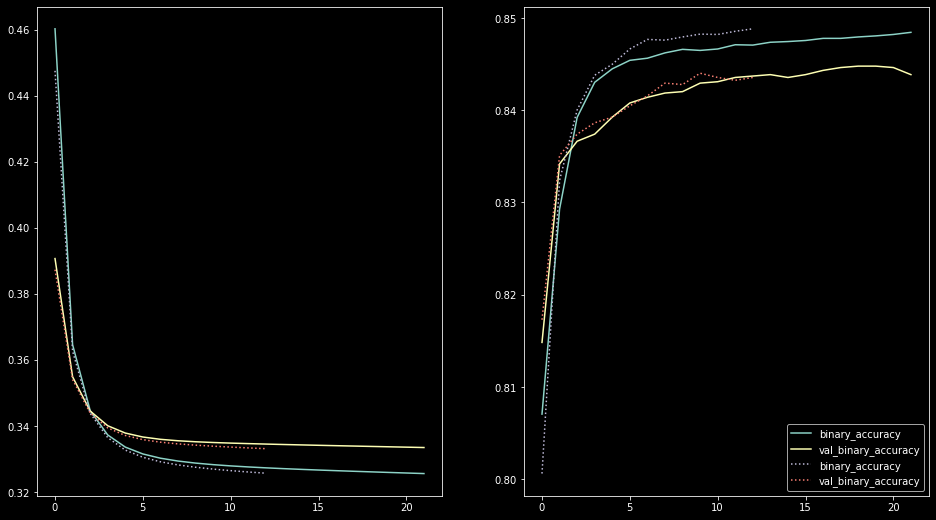

In [318]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

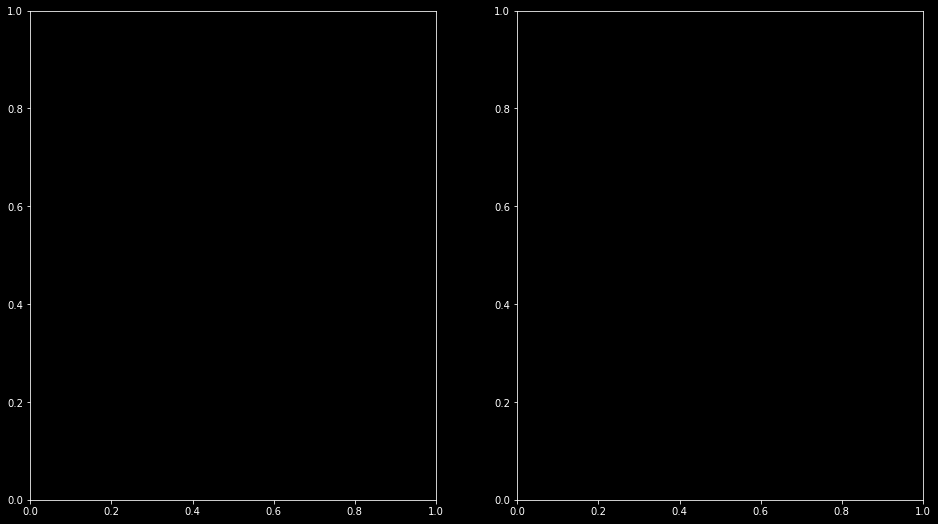

In [319]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(orthogonality_tracker.kappas[layer.name + '_u'])
        plt.plot(orthogonality_tracker.kappas[layer.name + '_v'])
plt.show()

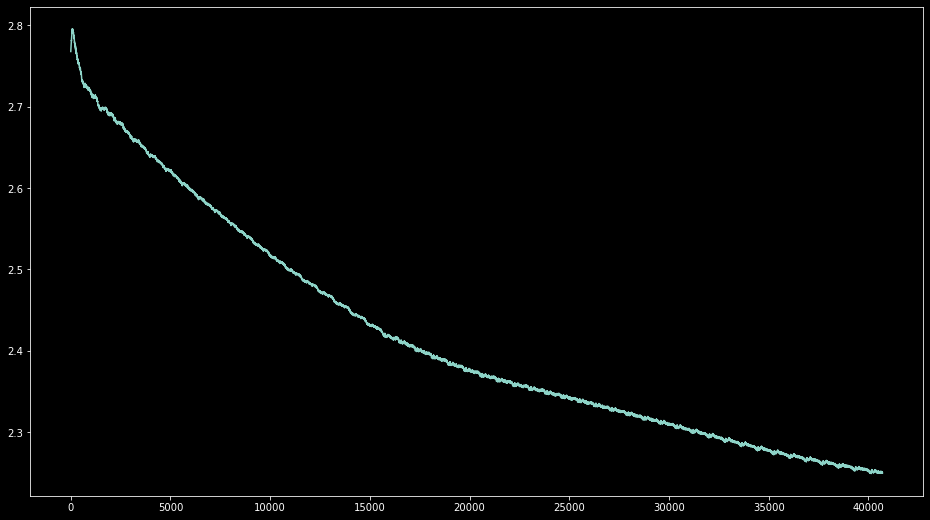

In [311]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappas[layer.name + '_s'])
plt.show()